<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_10_Unsupervised_Learning_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Objectives

To understand the type of patients who got admitted to ICU and compare them in terms of in-hospital mortality rate. 

---

# 2. Setting up

**Packages for data handling and visualization**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Authentication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in Week 5 notebook, grant Colab access to your Google Drive and import it to the current notebook. You would need to authenticate yourself. 

Alternatively, when you are working on your own analysis, you may also put everything (i.e. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,...,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,...,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0


---

# 3. Principal Component Analysis (PCA)

![](https://blog.bioturing.com/wp-content/uploads/2018/11/Blog_pca_6b.png)

([Source](https://blog.bioturing.com/2018/06/14/principal-component-analysis-explained-simply/))

Here, we attempt to reduce the dataset into smaller set of variables by using PCA. By evaluating the extracted principal components (PC), we can also know which variables contain the most unique information and which variables are redundant.

In [7]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

In [8]:
X = df[features_list]

# note that we do not define y as we do not have a prediction target in PCA or unsupervised learning in general

Before we do PCA, it is important to scale all input variables to zero mean and unit variance via `StandardScaler()` because the scale of variables matters in PCA (and most machine learning algorithms, but logistic regression and random forest are exceptions). For example, `GENDER_F`, `AGE` and `INPUTS_CV_COUNT_DAY` all have vastly different ranges. 

In [9]:
X[['GENDER_F', 'AGE', 'INPUTS_CV_COUNT_DAY']].describe()

,GENDER_F,AGE,INPUTS_CV_COUNT_DAY
count,58976.000000,58976.000000,58976.000000
mean,0.441298,54.682990,20.945233
std,0.496546,27.111229,43.226989
min,0.000000,0.000000,0.000000
25%,0.000000,43.000000,0.000000
50%,0.000000,61.000000,2.500000
75%,1.000000,75.000000,24.400000
max,1.000000,90.000000,1176.000000


In [10]:
# standardise all input columns
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [11]:
# after scaling, all columns have mean around 0 and standard deviation around 1
X[['GENDER_F', 'AGE', 'INPUTS_CV_COUNT_DAY']].describe()

,GENDER_F,AGE,INPUTS_CV_COUNT_DAY
count,5.897600e+04,5.897600e+04,5.897600e+04
mean,2.238066e-15,1.378721e-14,1.397554e-14
std,1.000008e+00,1.000008e+00,1.000008e+00
min,-8.887426e-01,-2.017004e+00,-4.845448e-01
25%,-8.887426e-01,-4.309317e-01,-4.845448e-01
50%,-8.887426e-01,2.330054e-01,-4.267100e-01
75%,1.125185e+00,7.494010e-01,7.992219e-02
max,1.125185e+00,1.302682e+00,2.672091e+01


---

## 3.1. Training

We can use the function `PCA()` from Scikit-learn to perform PCA. Similar to other Scikit-learn models, we first define a model, then train it using `.fit()`. Here, we specify that we want to retain 10 PCs. 

It is advisable to start with a smaller number of PCs and see if the explained variance ratio is satisfactory (depending on size and quality of dataset, this could range between 60% to 99%). If this number is too low, you could increase the number of PCs through the input `n_components` then retrain your model. Note that having more PCs could limit the explainability or understandability of your model, especially under a clinical context. 

In [12]:
# 1. Specify a model to be trained
model_pca = PCA(n_components = 10, random_state = 1)

# 2. Train the model
model_pca.fit(X)

PCA(n_components=10, random_state=1)

After training the model, we should first use `.explained_variance_ratio_` to check how much variance from the original features is retained by the PCs. In this case, we add them up and we can see that 59.3% of the variance is retained from the first 10 PCs. 

In [13]:
model_pca.explained_variance_ratio_

array([0.13800928, 0.06948064, 0.06637856, 0.06361622, 0.05358456,
       0.04917987, 0.04209835, 0.03902988, 0.03792361, 0.03344714])

In [14]:
sum(model_pca.explained_variance_ratio_)

0.5927481104234386

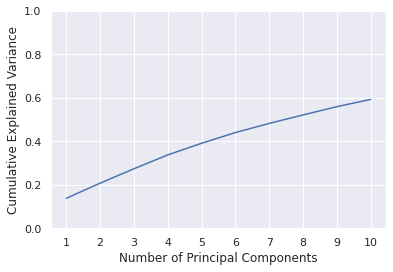

In [15]:
g = sns.lineplot(
    x = range(1, 1 + model_pca.n_components), 
    y = np.cumsum(model_pca.explained_variance_ratio_)
)
g.set(
    xlabel = 'Number of Principal Components', 
    ylabel = 'Cumulative Explained Variance', 
    xticks = range(1, 1 + model_pca.n_components), 
    ylim = [0, 1]
)
g

---

## 3.2. Item Loadings

To understand what information is captured from each PC, we can evaluate their respective item loadings. In the code below, we first apply the formula for computing item loadings, then convert the results to a DataFrame for easier use later. 

In [16]:
df_pca_loadings = pd.DataFrame(
    data = model_pca.components_.T * np.sqrt(model_pca.explained_variance_) / np.std(X).values.reshape((len(features_list), 1)), # equation to computing item loadings
    index = features_list,  # list of row names
    columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)] # list of column names
).rename_axis('Feature')

df_pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Feature,,,,,,,,,,
GENDER_F,0.011945,-0.012239,0.007240,-0.168044,0.205159,0.204352,0.261795,-0.029278,0.243589,-0.051878
AGE,0.823388,-0.177244,0.065581,-0.289662,-0.153311,0.145724,-0.037732,-0.037963,-0.054656,-0.011981
LOS,-0.097933,-0.010882,0.822157,-0.058465,0.118384,-0.241265,-0.023006,0.021698,0.102421,-0.074277
LOS_ICU,-0.148705,0.037772,0.805936,0.128326,0.137207,-0.169911,0.031619,0.070417,0.177659,-0.080357
CALLOUT_COUNT_DAY,0.297460,0.045797,-0.402755,-0.126212,0.089152,-0.238029,-0.025317,0.010836,0.024112,-0.101985
PRES_COUNT_DAY,0.665665,0.130342,-0.208048,0.401619,0.015769,-0.029585,0.053083,0.010900,0.206122,-0.112169
PROC_COUNT_DAY,0.235292,0.105722,-0.215281,0.517983,-0.115574,0.288262,0.083741,0.022147,0.050778,0.065573
CPT_COUNT_DAY,0.624516,0.203251,-0.005329,0.219275,0.230909,-0.204950,0.061167,0.146959,0.074498,-0.227465
LAB_COUNT_DAY,0.649498,0.171737,0.048331,0.525449,0.045657,0.149303,0.045635,0.020731,0.023919,0.098966


For the first 5 PCs, we then extract the important features, defined as the ones with the loadings > 0.5 or < -0.5. 

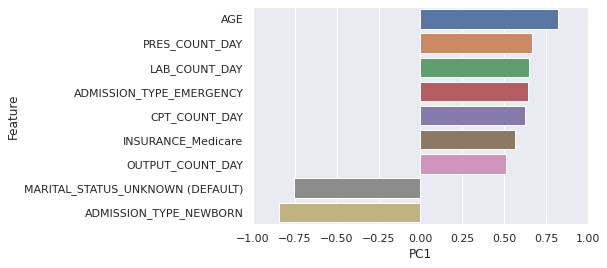

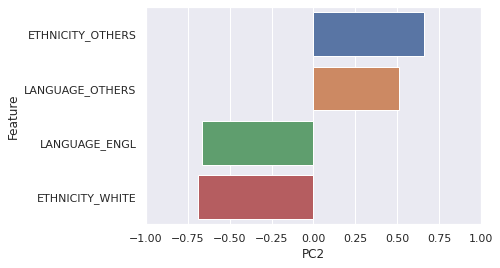

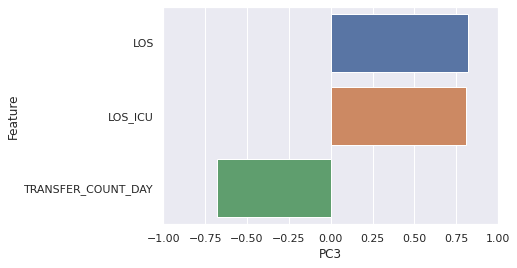

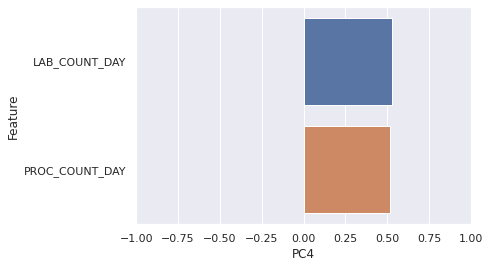

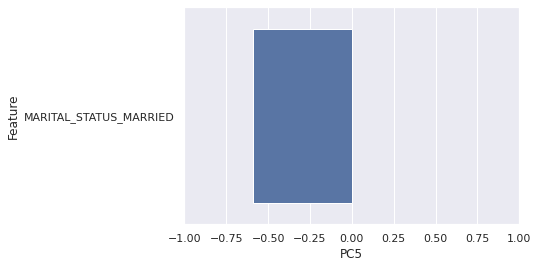

In [17]:
for col_name in df_pca_loadings.columns[:5]:
  tmp_df = df_pca_loadings[col_name].sort_values(key = lambda value: abs(value), ascending = False) \
    .sort_values(ascending = False)

  tmp_df = tmp_df[abs(tmp_df) > 0.5] # you can adjust this threshold to see more/less features

  # plot it
  g = sns.barplot(x = tmp_df, y = tmp_df.index)
  g.set(xlim = [-1, 1])
  plt.show()
  print()

We typically only focus on the first few PCs as they explain the most variance. To summarise the meaning for each PC after examining the item loadings:

PC | Explained Variance | Key Features
---|---|---
1 | 13.8% | Age, Daily average lab and prescription events
2 | 7.0% | Demographics (Ethnicity, Language)
3 | 6.6% | Length of Stay
4 | 6.4% | Daily average lab and procedure events
5 | 5.4% | Demographics (Marital status, Language, Ethnicity)

---

# 4. Clustering

Clustering refers to a technique of partitioning entities or objects (e.g. patients, diseases) with similar characteristics into distinct groups while maximizing dissimilarity between groups. In clinical datasets, the major objectives of performing clustering could be to:

* Extract insights from the dataset. **Understand** what **subgroups or phenotypes** exist within the dataset. (e.g. [discovering asthma subtypes](https://pubmed.ncbi.nlm.nih.gov/18480428/))
* Evaluate the **association** between extracted subgroups with other variables or **clinical outcomes**. (e.g. [subgroups of adult-onset diabetes and their association with outcomes](https://pubmed.ncbi.nlm.nih.gov/29503172/))
* Use the extracted patient groups as one of the features or outcome in a **subsequent prediction model**. (e.g. [modelling and predicting osteoarthritis progression](https://pubmed.ncbi.nlm.nih.gov/30130590/))

K-means clustering and hierachical clustering are two widely used clustering algorithms. 

---

## 4.1. K-means Clustering

In K-means, this is achieved by iteratively update groupings and their respective centroids. 

[![](http://shabal.in/visuals/kmeans/random.gif)](http://shabal.in/visuals/kmeans/random.gif)

([Source](http://shabal.in/visuals/kmeans/6.html))

In our example, we will apply K-means clustering to the **extracted PCs**. Note that we do not apply it on the features `X` directly as K-means clustering works best when used on **continuous variables of the same scale** instead of categorical variables. 

### 4.1.1. Training

First, let's extract the value of the 5 PCs for all hospital admissions.

In [18]:
X_pc = model_pca.transform(X) # apply the PCA model above to obtain PCs
X_pc = pd.DataFrame(X_pc, 
                    index = X.index, 
                    columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)]) # convert it to a table by adding column names

X_pc

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.769653,-0.741212,-0.559447,-1.329069,1.609875,1.012365,0.566704,1.593975,0.322901,0.074456
1,-0.951058,1.785670,0.249042,-0.681163,2.730297,0.476968,-2.730190,-1.475379,-0.842303,0.731930
2,0.794429,-1.293927,0.891760,-1.648593,0.792820,1.628621,0.173627,0.843029,0.114672,0.852427
3,1.407164,-1.302371,-0.445769,-1.459067,-0.258651,0.167406,-1.385319,1.303695,-0.607147,-0.387038
4,2.329616,-0.791974,0.328283,0.063002,0.721819,1.887241,0.359604,0.833688,0.817467,0.586549
...,...,...,...,...,...,...,...,...,...,...
58971,0.130367,4.631781,-1.182907,1.450969,-2.117963,1.220980,0.571451,1.646455,-1.233803,0.236020
58972,1.667013,5.660846,-0.614442,-1.931973,-0.824591,-0.174520,0.695431,1.378117,1.461676,0.000739
58973,1.715097,2.957185,-1.776676,-0.064974,-2.100530,-3.048228,0.081891,2.487531,1.312328,0.458260
58974,1.098480,0.669461,-0.901287,-0.856405,1.005190,1.374952,-0.078578,-0.838142,-1.236467,-0.294752


Second, we define a K-means model with 4 clusters and train it. Next, extract the cluster number from the model, and append it as a new column called 'cluster'. 

In [19]:
# 1. Specify a model to be trained
model_kmeans_4 = KMeans(n_clusters = 4, random_state = 1)

# 2. Train the model
model_kmeans_4.fit(X_pc)

# 3. Extract cluster number
X_pc['cluster'] = model_kmeans_4.predict(X_pc)
X_pc['cluster'] = X_pc['cluster'].map(dict(X_pc['cluster'].value_counts().rank().astype(int))) # rename categories such that 1 is the smallest group and 4 is the largest group
X_pc['cluster'] = pd.Categorical(X_pc['cluster'])
X_pc['cluster']

0        3
1        3
2        3
3        4
4        3
        ..
58971    1
58972    1
58973    1
58974    3
58975    3
Name: cluster, Length: 58976, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [20]:
X_pc['cluster'].value_counts()

4    23285
3    22981
2     8222
1     4488
Name: cluster, dtype: int64

Plots can help us understand how the dataset is partitioned by the algorithm. The scatter plot below is an example. Note that while we used all 10 PCs for clustering, we only chose the 2-most important PCs for visualization as they accounted for the most variance.

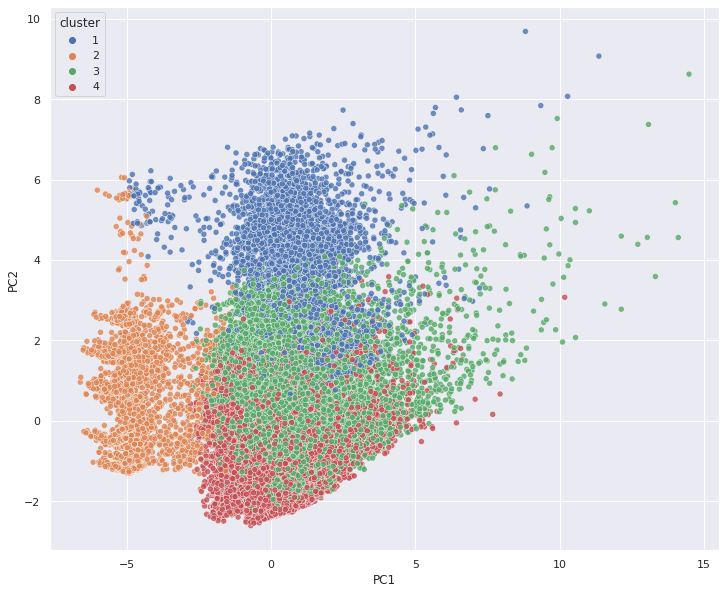

In [21]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = X_pc, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

* Each dot represents a patient, and depicts the respective position after being "projected" to PC1 and PC2. 
* The closer two dots are, the more similar the two patients are data-wise.

---

### 4.1.2. Choosing the number of Clusters

Depending on your dataset and research question, you should experiment with different number of clusters. Typically, 3~6 clusters yield the best results in terms of interpretation and clinical understanding. 

The simplest way to determine the number of clusters is called the **"Elbow method"** which involves plotting a graph of within-cluster distance against number of clusters. Within-cluster distance is a measure of dispersion of data points within the same cluster, and the decreases with the number of clusters. Intuitively, we imagine that the plot resembles an arm, then the "elbow" (the point of inflection on the curve) would indicate a reasonable choice of number of clusters. 

In [22]:
# run KMeans once from 2 clusters to 12. Extract the distance for each and add it to `ssd_list`
ssd_list = []
n_cluster_list = range(2, 13)
for n_cluster in n_cluster_list:
    model_kmeans_tmp = KMeans(n_clusters=n_cluster)
    model_kmeans_tmp.fit(X_pc)
    ssd_list.append(model_kmeans_tmp.inertia_)

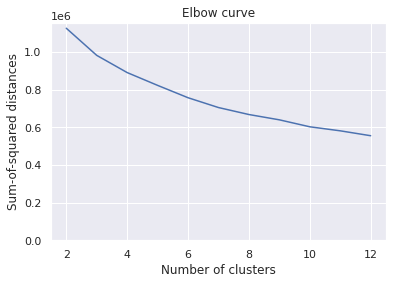

In [23]:
g = sns.lineplot(x = n_cluster_list, y = ssd_list)
g.set(
    title = 'Elbow curve', 
    xlabel = 'Number of clusters', 
    ylabel = 'Sum-of-squared distances', 
    ylim = (0, None)
)
plt.show()

* 4 clusters could still be a reasonable choice here.

---

## 4.2. Understanding the Clusters

### 4.2.1. Intuition

To understand the characteristics of each cluster, we can start off by comparing the scatter plot above with "driving forces" of PC1 and PC2. Although this isn't necessary, this helps us gain some intuition about how item loadings relate to patient characteristics. Here, we plot the 5-most influential item loadings of the two PCs on the same axes. 

In [24]:
# the longer the arrows are, the more influential the feature is in terms of PC1 and 2. 
tmp_df = df_pca_loadings[['PC1', 'PC2']].copy()
tmp_df['distance'] = np.sqrt(np.square(tmp_df['PC1']) + np.square(tmp_df['PC2'])) # distance formula
tmp_df = tmp_df.sort_values(by = 'distance', key = lambda value: abs(value), ascending = False)
tmp_df['rank'] = tmp_df.reset_index().index + 1
tmp_df.head()

,PC1,PC2,distance,rank
Feature,,,,
ADMISSION_TYPE_NEWBORN,-0.848097,0.053199,0.849764,1
AGE,0.823388,-0.177244,0.842249,2
MARITAL_STATUS_UNKNOWN (DEFAULT),-0.756616,0.115464,0.765376,3
ETHNICITY_WHITE,0.134213,-0.691448,0.704353,4
PRES_COUNT_DAY,0.665665,0.130342,0.678306,5


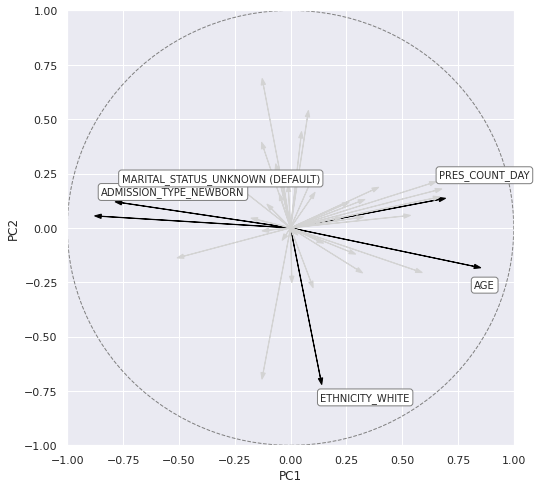

In [25]:
# unfortunately, the plot below is slightly more complex and cannot be plotted using purely seaborn functions (e.g. `sns.lineplot`). We use `plt.annotate` instead.
plt.figure(figsize = (8, 8)) \
  .add_subplot().add_patch(plt.Circle((0, 0), radius=1, edgecolor='gray', ls='--', fc='None')) # plot a circle
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

# loop through the rows above and draw an arrow for each. 
for index, row in tmp_df.iterrows():
  if row['rank'] > 5: 
    # draw a grey arrow if it's less important
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='lightgrey', head_width=0.02)
  else: 
    # draw a labelled black arrow if it's one of the most influential factors
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='black', head_width=0.02)
    plt.annotate(index, xy=(0,0), xytext=(row['PC1'], row['PC2'] + np.sign(row['PC2'])*0.1),
        bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

* The most influential factor is `AGE`. 
* A patient with high `AGE` is essentially dragged towards the direction the arrow points to. If we also take the previous scatter plot above into consideration, we can speculate that cluster 2 patients have a relatively low `AGE`.


Next, we evaluate the clusters by **comparing** the feature values of each cluster **graphically** and **statistically**. Data exploration techniques from Week 5 can also be applied here.

In [26]:
# make a DataFrame that combines all info: features, PCs and cluster
df_clustered = pd.concat([df, X_pc], axis = 1)
df_clustered.head(5)

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,cluster
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,...,-0.741212,-0.559447,-1.329069,1.609875,1.012365,0.566704,1.593975,0.322901,0.074456,3
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,...,1.785670,0.249042,-0.681163,2.730297,0.476968,-2.730190,-1.475379,-0.842303,0.731930,3
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,...,-1.293927,0.891760,-1.648593,0.792820,1.628621,0.173627,0.843029,0.114672,0.852427,3
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,...,-1.302371,-0.445769,-1.459067,-0.258651,0.167406,-1.385319,1.303695,-0.607147,-0.387038,4
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,...,-0.791974,0.328283,0.063002,0.721819,1.887241,0.359604,0.833688,0.817467,0.586549,3


We can calculate some descriptive statistics by group/cluster. You can also apply statistical tests such as t-tests to compare whether there is a significant difference between groups. 

In the following sections, we highlight some distinctive features based on the top item loadings above.

If you simply want a summary table that includes all variables, run the following line:

In [27]:
with pd.option_context('display.max_rows', 200):
  display(df_clustered[features_list + ['cluster']].groupby('cluster').agg(['mean', 'std']).T)

cluster                                        1          2          3  \
GENDER_F                         mean   0.441845   0.459012   0.562334   
                                 std    0.496662   0.498347   0.496110   
AGE                              mean  65.285651   1.046096  61.896132   
                                 std   19.385603   6.712378  19.692438   
LOS                              mean  10.737244  11.549143   9.637060   
                                 std   12.256137  20.138252  10.449072   
LOS_ICU                          mean   4.640728   9.783260   4.320579   
                                 std    7.540271  20.547570   6.373268   
CALLOUT_COUNT_DAY                mean   0.105437   0.000962   0.114138   
                                 std    0.127317   0.013756   0.150216   
PRES_COUNT_DAY                   mean   9.012966   0.687512   9.929540   
                                 std    6.072286   1.570918   7.278500   
PROC_COUNT_DAY                   mean   0.528286   0.391887   0.559417   
                                 std    0.654671   0.455583   0.830892   
CPT_COUNT_DAY                    mean   1.121972   0.015808   1.234609   
                                 std    0.831524   0.100430   0.913154   
LAB_COUNT_DAY                    mean  41.706811   8.853760  45.730867   
                                 std   26.066448  10.339472  30.594168   
INPUTS_CV_COUNT_DAY              mean  20.469027  10.900163  21.105957   
                                 std   43.311916  19.767356  46.158448   
INPUTS_MV_COUNT_DAY              mean   6.734495   0.033052   7.720408   
                                 std   14.905873   0.642281  16.496216   
OUTPUT_COUNT_DAY                 mean   6.992118   0.860960   7.027534   
                                 std    6.167707   1.591104   6.182790   
TRANSFER_COUNT_DAY               mean   0.685074   0.995531   0.742834   
                                 std    0.533656   0.720778   0.608173   
MICRO_COUNT_DAY                  mean   1.232160   0.238808   1.376672   
                                 std    1.987619   0.400969   2.819668   
ADMISSION_TYPE_ELECTIVE          mean   0.108957   0.005351   0.055089   
                                 std    0.311620   0.072962   0.228159   
ADMISSION_TYPE_EMERGENCY         mean   0.856952   0.042325   0.931291   
                                 std    0.350161   0.201343   0.252964   
ADMISSION_TYPE_NEWBORN           mean   0.016488   0.947215   0.000044   
                                 std    0.127358   0.223618   0.006597   
ADMISSION_TYPE_URGENT            mean   0.017602   0.005108   0.013576   
                                 std    0.131516   0.071294   0.115727   
RELIGION_CATHOLIC                mean   0.310606   0.255656   0.319829   
                                 std    0.462793   0.436256   0.466420   
RELIGION_NOT SPECIFIED           mean   0.239973   0.177329   0.238066   
                                 std    0.427114   0.381970   0.425909   
RELIGION_UNOBTAINABLE            mean   0.133021   0.357334   0.120839   
                                 std    0.339636   0.479244   0.325947   
RELIGION_OTHERS                  mean   0.316399   0.209681   0.321265   
                                 std    0.465123   0.407106   0.466973   
INSURANCE_Medicare               mean   0.560383   0.000486   0.611070   
                                 std    0.496396   0.022053   0.487518   
INSURANCE_Private                mean   0.153743   0.796886   0.185719   
                                 std    0.360743   0.402341   0.388888   
INSURANCE_Medicaid               mean   0.192513   0.149234   0.147644   
                                 std    0.394318   0.356340   0.354754   
INSURANCE_OTHERS                 mean   0.093360   0.053393   0.055568   
                                 std    0.290969   0.224830   0.229090   
MARITAL_STATUS_MARRIED           mean   0.505793   0.000365   0.050825   
    

### 4.2.1. Features related to Age

An easy way to compare basic statistics per cluster is to use `.describe()` after `.groupby()`.

In [28]:
df_clustered[['AGE', 'ADMISSION_TYPE_NEWBORN', 'cluster']].groupby('cluster').describe()

AGE                                                     \
           count       mean        std  min   25%   50%   75%   max   
cluster                                                               
1         4488.0  65.285651  19.385603  0.0  55.0  69.0  80.0  90.0   
2         8222.0   1.046096   6.712378  0.0   0.0   0.0   0.0  90.0   
3        22981.0  61.896132  19.692438  0.0  48.0  64.0  79.0  90.0   
4        23285.0  64.459781  14.357492  0.0  55.0  65.0  76.0  90.0   

        ADMISSION_TYPE_NEWBORN                                               
                         count      mean       std  min  25%  50%  75%  max  
cluster                                                                      
1                       4488.0  0.016488  0.127358  0.0  0.0  0.0  0.0  1.0  
2                       8222.0  0.947215  0.223618  0.0  1.0  1.0  1.0  1.0  
3                      22981.0  0.000044  0.006597  0.0  0.0  0.0  0.0  1.0  
4                      23285.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

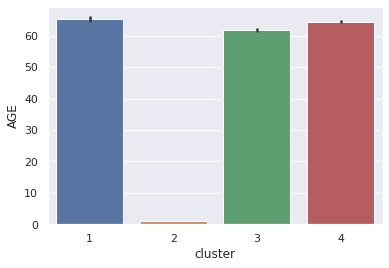

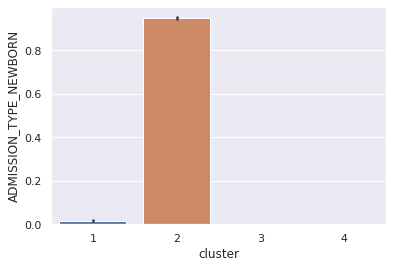

In [29]:
for col_name in ['AGE', 'ADMISSION_TYPE_NEWBORN']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 patients are much younger and `ADMISSION_TYPE_NEWBORN` is much more likely to be 1 (*infants*).
* The difference in `AGE` for the other groups may not be significant visually. Further statistical analysis is needed to draw conclusions.

For statistical tests, we can begin by conducting a one-way ANOVA F-test for overall difference and then Tukey's HSD post-hoc test for pairwise difference. Using `AGE` as an example here:

In [30]:
# specify the independent and dependent variables in our test
# The general structure for entering the equation is "dependent_variable ~ C(independent_variable)"
model_ols = ols(formula='AGE ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.757993e+07,9.193310e+06,34383.234849,0.0
Residual,58972.0,1.576780e+07,2.673777e+02,NaN,NaN


In [31]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['AGE'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -64.2396  0.001 -65.0192 -63.4599   True
     1      3  -3.3895  0.001  -4.0751  -2.7039   True
     1      4  -0.8259 0.0105  -1.5107   -0.141   True
     2      3    60.85  0.001  60.3102  61.3899   True
     2      4  63.4137  0.001  62.8748  63.9526   True
     3      4   2.5636  0.001    2.173   2.9543   True
------------------------------------------------------


* Unsurprisingly, there is a statistically significant difference between the clusters in terms of `AGE` overall (F-statistic ~= 34,383, p-value < 0.05).
* All 4 clusters differed significantly from each other in terms of `AGE`. 

### 4.2.2. Features related to Event Counts

In [32]:
df_clustered[['PROC_COUNT_DAY', 'LAB_COUNT_DAY', 'cluster']].groupby('cluster').describe()

PROC_COUNT_DAY                                                         \
                 count      mean       std  min       25%       50%       75%   
cluster                                                                         
1               4488.0  0.528286  0.654671  0.0  0.187500  0.368421  0.625000   
2               8222.0  0.391887  0.455583  0.0  0.180455  0.333333  0.500000   
3              22981.0  0.559417  0.830892  0.0  0.166667  0.363636  0.666667   
4              23285.0  0.584572  0.658621  0.0  0.250000  0.428571  0.714286   

              LAB_COUNT_DAY                                                   \
          max         count       mean        std  min        25%        50%   
cluster                                                                        
1         8.0        4488.0  41.706811  26.066448  0.0  29.250000  37.261364   
2        11.0        8222.0   8.853760  10.339472  0.0   3.538462   7.053102   
3        20.0       22981.0  45.730867  30.594168  0.0  30.535714  39.250000   
4        14.0       23285.0  40.121185  21.175116  0.0  29.200000  37.000000   

                           
               75%    max  
cluster                    
1        48.000000  440.0  
2        10.333333  169.0  
3        51.272727  492.0  
4        46.800000  507.0

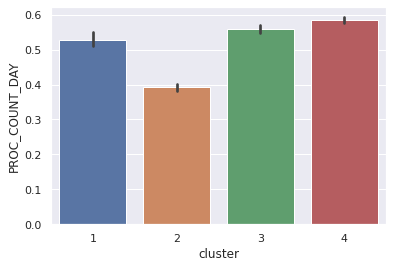

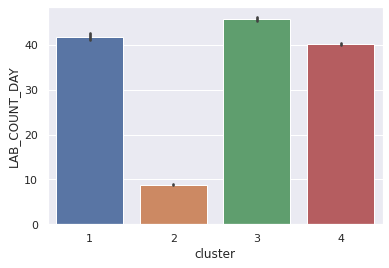

In [33]:
for col_name in ['PROC_COUNT_DAY', 'LAB_COUNT_DAY']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 had the lowest `LAB_COUNT_DAY` and `PROC_COUNT_DAY`.
* Among the 3 remaining groups, Cluster 4 patients had a lower `LAB_COUNT_DAY` but higher `PROC_COUNT_DAY`. 

In [34]:
# specify the independent and dependent variables in our test. 
model_ols = ols(formula='LAB_COUNT_DAY ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,8.524264e+06,2.841421e+06,4670.50058,0.0
Residual,58972.0,3.587716e+07,6.083762e+02,NaN,NaN


In [35]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['LAB_COUNT_DAY'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     1      2 -32.8531 0.001 -34.0291 -31.677   True
     1      3   4.0241 0.001   2.9899  5.0582   True
     1      4  -1.5856 0.001  -2.6187 -0.5526   True
     2      3  36.8771 0.001  36.0628 37.6914   True
     2      4  31.2674 0.001  30.4545 32.0803   True
     3      4  -5.6097 0.001  -6.1989 -5.0205   True
----------------------------------------------------


* From our ANOVA F-test, there is a statistically significant difference between the clusters in terms of `LAB_COUNT_DAY` (F-statistic ~= 4,670, p-value < 0.05).
* In addition, based on Tukey's HSD, all 4 clusters differed significantly in terms of `LAB_COUNT_DAY` (even between cluster 1 and cluster 4 patients, which looked the closest in the bar chart). 

### 4.2.3. Features related to LOS

In [36]:
df_clustered[['LOS', 'LOS_ICU', 'cluster']].groupby('cluster').describe()

LOS                                                            \
           count       mean        std  min       25%       50%        75%   
cluster                                                                      
1         4488.0  10.737244  12.256137  1.0  4.086458  7.105556  12.792014   
2         8222.0  11.549143  20.138252  1.0  2.325000  4.086806   9.833681   
3        22981.0   9.637060  10.449072  1.0  3.659722  6.646528  11.810417   
4        23285.0  10.056539  10.544345  1.0  4.283333  7.034722  11.892361   

                     LOS_ICU                                               \
                max    count      mean        std  min       25%      50%   
cluster                                                                     
1        169.159722   4488.0  4.640728   7.540271  0.0  1.215825  2.20560   
2        294.660417   8222.0  9.783260  20.547570  0.0  0.138700  0.82305   
3        202.762500  22981.0  4.320579   6.373268  0.0  1.194500  2.17050   
4        206.425694  23285.0  4.380789   6.796152  0.0  1.183600  2.15960   

                            
             75%       max  
cluster                     
1        4.73415  169.4202  
2        9.11240  260.7089  
3        4.47420  116.8327  
4        4.35120  153.9280

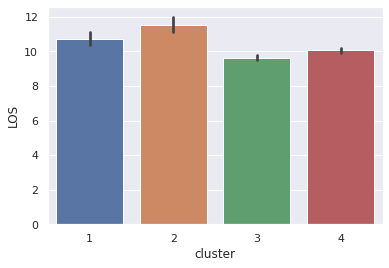

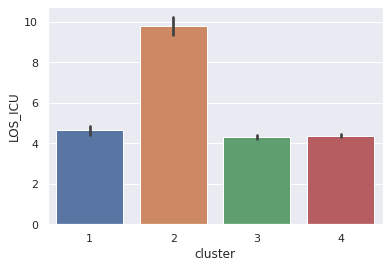

In [37]:
for col_name in ['LOS', 'LOS_ICU']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 patients had a longer LOS and LOS in ICU. 

In [38]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='LOS ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.389247e+04,7964.155248,51.57811,2.772177e-33
Residual,58972.0,9.105843e+06,154.409598,NaN,NaN


In [39]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['LOS'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.8119 0.0024  0.2194  1.4044   True
     1      3  -1.1002  0.001 -1.6212 -0.5792   True
     1      4  -0.6807 0.0043 -1.2011 -0.1603   True
     2      3  -1.9121  0.001 -2.3223 -1.5018   True
     2      4  -1.4926  0.001 -1.9021 -1.0831   True
     3      4   0.4195 0.0016  0.1226  0.7163   True
----------------------------------------------------


* While the bar chart for `LOS` may look close, it is significantly different across all clusters, including pairwise comparison.

### 4.2.4. Categorical Features

As for categorical features such as `ETHNICITY` and `LANGUAGE`, it is best to compute the distribution of category per cluster instead.

In [40]:
# calculate the % distribution of ethnicity per cluster
tmp_df_ethnicity = df_clustered[['ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS', 'cluster']].groupby('cluster')
tmp_df_ethnicity.mean()

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
cluster,,,,
1,0.338012,0.034537,0.061943,0.565508
2,0.602530,0.108733,0.068110,0.220628
3,0.691789,0.159262,0.062791,0.086158
4,0.799957,0.031394,0.096285,0.072364


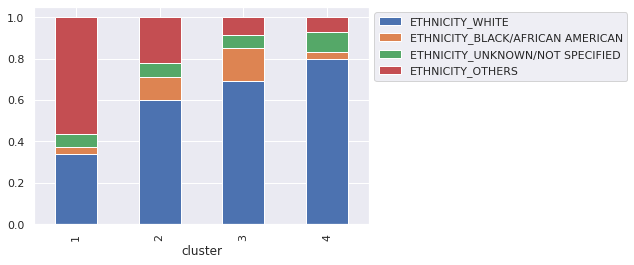

In [41]:
tmp_df_ethnicity.mean().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

In [42]:
tmp_df_language = df_clustered[['LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS', 'cluster']].groupby('cluster').mean()
tmp_df_language

,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS
cluster,,,,
1,0.000000,0.240419,0.175579,0.584002
2,0.991486,0.000486,0.000243,0.007784
3,1.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000


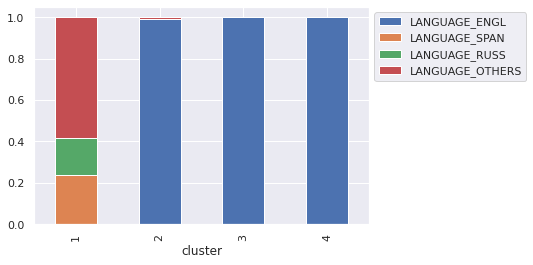

In [43]:
tmp_df_language.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

In [44]:
tmp_df_maritalstatus = df_clustered[['MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS', 'cluster']].groupby('cluster').mean()
tmp_df_maritalstatus

,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS
cluster,,,,
1,0.505793,0.216800,0.066845,0.210561
2,0.000365,0.036852,0.962540,0.000243
3,0.050825,0.475697,0.075018,0.398460
4,0.893193,0.044922,0.022976,0.038909


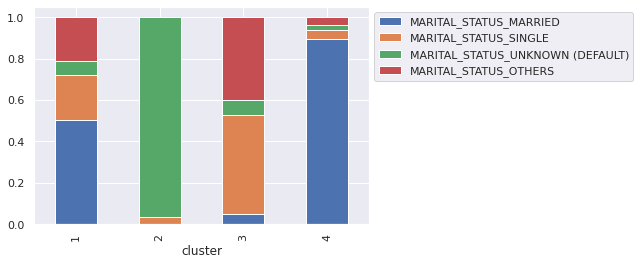

In [45]:
tmp_df_maritalstatus.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left") # move legend so that it won't cover the main graph

* Cluster 1 is primarily comprised of **non-english speakers**. They are also less likely to be white. 
* The key distinction between cluster 3 and 4 patients is marital status: cluster 4 patients are predominantly married. 

For statistically tests, we may use Chi-square test of independence of variables in a contingency table. The following line outputs the Chi-square test statistic and p-value respectively, showing that ethnicity is significantly different across groups as p-value < 0.05. 

In [46]:
chi2_contingency(tmp_df_ethnicity.sum())[:2]

(11365.724622274807, 0.0)

### 4.2.5. External Features

Associating clusters with other variables that were NOT used for clustering could also provide some interesting insights. In this case, `IN_HOSP_DEATH` was not used in clustering but the mortality rates across clusters are found to be quite different. 

In [47]:
df_clustered[['IN_HOSP_DEATH', 'cluster']].groupby('cluster').describe()

IN_HOSP_DEATH                                             
                count      mean       std  min  25%  50%  75%  max
cluster                                                           
1              4488.0  0.119207  0.324068  0.0  0.0  0.0  0.0  1.0
2              8222.0  0.010216  0.100565  0.0  0.0  0.0  0.0  1.0
3             22981.0  0.135721  0.342499  0.0  0.0  0.0  0.0  1.0
4             23285.0  0.090874  0.287436  0.0  0.0  0.0  0.0  1.0

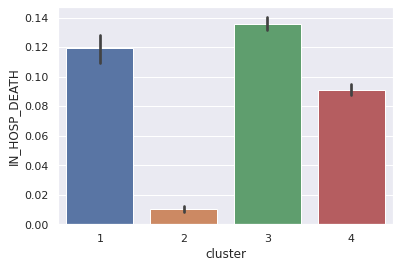

In [48]:
sns.barplot(data = df_clustered, x = 'cluster', y = 'IN_HOSP_DEATH')

In [49]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='IN_HOSP_DEATH ~ C(cluster)', data=df_clustered).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,99.164077,33.054692,376.766591,2.022322e-242
Residual,58972.0,5173.763691,0.087733,NaN,NaN


In [50]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered['IN_HOSP_DEATH'], groups=df_clustered['cluster'])
print(tmp_tukeyhsd)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   -0.109  0.001 -0.1231 -0.0949   True
     1      3   0.0165 0.0036  0.0041  0.0289   True
     1      4  -0.0283  0.001 -0.0407 -0.0159   True
     2      3   0.1255  0.001  0.1157  0.1353   True
     2      4   0.0807  0.001  0.0709  0.0904   True
     3      4  -0.0448  0.001 -0.0519 -0.0378   True
----------------------------------------------------


* Cluster 1 and 3 patients had a remarkably higher mortality rate, and is significantly higher than the other groups. 
* In contrast, Cluster 2 patients had a much lower mortality rate. 

---

## 4.3. Conclusions

From all the results presented, we uncovered 4 types of patients within the data, and are able to deduce the characteristics for each patient group as follows:

Cluster/Patient Group | Characteristics
---|---
1 | Non-english speakers
2 | Newborn
3 | (Other patients)
4 | Patients who are married

<br>

Note that even *without* using `IN_HOSP_DEATH` as one of the input variables in PCA and K-means clustering, the 4 patient groups demonstrated drastically different levels of in-hospital mortality. Specifically, in-hospital mortality rate is higher among Cluster 1 and 3 patients. 

From this point, one can extend this cluster analysis by, for example,

* building a predictive model using clusters as an additional feature
* exploring the association between clusters and certain clinical outcomes

---

# Exercise

Using PCA and K-means clustering, explore the type of countries within [COVID-19 worldwide dataset](https://github.com/owid/covid-19-data/blob/master/public/data/) by comparing the latest per-capita statistics up until Mar 01, 2022. Deduce the characteristics of the extracted PCs and clusters. 

Here are some pre-processing codes to help you get started. Note that your results may not be exactly the same as the dataset is constantly being updated.

In [51]:
df_covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [52]:
df_covid_filtered = df_covid[df_covid['date'] <= '2022-03-01'] # filter by date
df_covid_filtered = df_covid_filtered[~df_covid_filtered['iso_code'].str.startswith('OWID_')] # removes non-country locations such as "Worldwide", "Asia" and "Low income"

# list of features we will be using for this exercise
features_list_covid = [
  'total_cases_per_million', 'new_cases_smoothed_per_million', 
  'total_deaths_per_million', 'new_deaths_smoothed_per_million', 
  'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 
  'positive_rate', 
  'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
  'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred', 
  'new_vaccinations_smoothed_per_million', 'new_people_vaccinated_smoothed_per_hundred', 
  'stringency_index', 'human_development_index', 'gdp_per_capita']

len(features_list_covid)

16

In [53]:
df_covid_filtered = df_covid_filtered[features_list_covid + ['location']].groupby('location').last() # Obtain the latest figure if missing on Mar 01, 2022
df_covid_filtered = df_covid_filtered.dropna() # exclude countries with incomplete data 
df_covid_filtered

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
location,,,,,,,,,,,,,,,,
Albania,94573.004,62.007,1208.521,1.044,552.997,0.092,0.6722,94.28,44.23,41.73,8.32,967.0,0.019,46.30,0.795,11803.431
Angola,2909.976,0.316,55.992,0.004,41.965,0.055,0.0058,47.92,31.21,16.06,0.41,1376.0,0.070,60.19,0.581,5819.495
Argentina,195242.086,152.086,2768.440,2.002,753.262,0.630,0.0860,205.24,88.48,79.14,36.98,3291.0,0.038,37.04,0.845,18933.907
Australia,126289.150,872.619,204.318,1.352,2465.985,3.149,0.2771,210.00,85.56,79.46,44.99,3645.0,0.033,51.39,0.944,44648.710
Austria,299072.041,2978.887,1641.146,3.317,17655.132,59.284,0.0502,199.40,75.21,72.61,55.45,593.0,0.006,57.41,0.922,45436.686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,237581.420,186.200,2862.015,5.470,2474.373,2.962,0.0360,167.20,76.52,65.10,28.66,822.0,0.022,58.80,0.926,54225.446
Uruguay,242284.985,845.054,2005.938,3.525,1638.063,2.949,0.2865,219.25,84.80,78.70,55.76,2062.0,0.017,20.37,0.817,20551.409
Vietnam,36239.905,970.787,410.904,1.334,807.886,1.051,0.9237,198.95,80.86,78.51,39.58,4228.0,0.010,66.67,0.704,6171.884


In [54]:
df_covid_filtered.describe()

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.00000,94.000000,94.00000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,150565.789628,685.050872,1520.773734,2.498223,2262.032447,5.43966,0.190443,150.43734,65.511277,60.027766,28.133830,2400.478723,0.066011,45.178830,0.795617,24266.303660
std,125640.683616,974.058967,1293.187131,2.709577,3973.231335,14.50710,0.183266,57.99219,19.269513,19.927007,21.078465,3300.607532,0.193050,17.921316,0.117858,18631.624316
min,75.993000,0.154000,3.210000,0.000000,39.363000,0.03600,0.000000,15.27000,13.150000,10.130000,0.150000,51.000000,0.000000,2.780000,0.456000,1136.103000
25%,42159.811000,36.640000,404.445750,0.445500,332.091000,0.59375,0.050025,110.04000,53.050000,47.752500,8.665000,667.250000,0.009000,33.562500,0.729500,8738.200250
50%,112610.487500,261.206500,1235.364000,1.557000,1131.307500,1.86150,0.138000,164.86000,71.050000,65.185000,27.710000,1262.500000,0.019000,46.065000,0.813000,19817.014500
75%,241109.093750,851.486250,2302.201000,3.524000,2263.166500,4.38400,0.265600,199.28750,80.285000,74.720000,47.260000,2598.000000,0.045500,59.145000,0.892000,34983.153000
max,478798.280000,4671.066000,6317.377000,12.370000,28794.551000,118.42700,0.923700,254.45000,98.900000,94.940000,75.010000,22600.000000,1.698000,84.260000,0.957000,94277.965000


In [55]:
# standardise all input columns
X_covid = pd.DataFrame(StandardScaler().fit_transform(df_covid_filtered), columns=df_covid_filtered.columns, index = df_covid_filtered.index)
X_covid

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed_per_hundred,stringency_index,human_development_index,gdp_per_capita
location,,,,,,,,,,,,,,,,
Albania,-0.448048,-0.643066,-0.242755,-0.539575,-0.432444,-0.370600,2.642833,-0.973553,-1.110323,-0.923163,-0.945044,-0.436636,-0.244821,0.062896,-0.005263,-0.672496
Angola,-1.181524,-0.706740,-1.138765,-0.925457,-0.561752,-0.373164,-1.012915,-1.777257,-1.789625,-2.218272,-1.322320,-0.312055,0.020776,0.842107,-1.830749,-0.995389
Argentina,0.357494,-0.550093,0.969973,-0.184119,-0.381770,-0.333316,-0.572953,0.950068,1.198363,0.964255,0.421928,0.271252,-0.145873,-0.456578,0.421252,-0.287736
Australia,-0.194259,0.193596,-1.023452,-0.425295,0.051607,-0.158746,0.475387,1.032588,1.046016,0.980400,0.803975,0.379080,-0.171912,0.348438,1.265752,1.099834
Austria,1.188330,2.367552,0.093581,0.303799,3.894975,3.731487,-0.769345,0.848825,0.506018,0.634802,1.302877,-0.550556,-0.312522,0.686152,1.078085,1.142353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,0.696289,-0.514882,1.042721,1.102648,0.053729,-0.171705,-0.847244,0.290600,0.574366,0.255906,0.025096,-0.480803,-0.229198,0.764130,1.112207,1.616595
Uruguay,0.733926,0.165145,0.377181,0.380975,-0.157885,-0.172606,0.526954,1.192947,1.006364,0.942056,1.317662,-0.103100,-0.255237,-1.391742,0.182403,-0.200456
Vietnam,-0.914822,0.294919,-0.862846,-0.431974,-0.367948,-0.304140,4.022516,0.841023,0.800800,0.932470,0.545938,0.556661,-0.291691,1.205626,-0.781521,-0.976374


## Suggested Solution

Note that your results may **not be exactly the same** as the dataset is constantly being updated.

### PCA

#### Training

In [56]:
# 1. Specify a model to be trained
model_pca_covid = PCA(n_components = 6, random_state = 1)

# 2. Train the model
model_pca_covid.fit(X_covid)

PCA(n_components=6, random_state=1)

In [57]:
model_pca_covid.explained_variance_ratio_

array([0.38255912, 0.16484501, 0.10930939, 0.09225229, 0.07029265,
       0.05781986])

* Here, I used 6 PCs, but it is also reasonable to set `n_components` to be any number that is at least 4 due to the higher % explained variance. If we retain 4 PCs only, we can still explain more than 70% of the variance. 

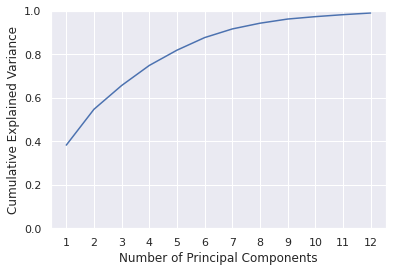

In [58]:
# train a temporary PCA model with 12 PCs so that we can visualise the relationship between PCs and explained variance better
tmp_model_pca_covid = PCA(n_components = 12, random_state = 1)
tmp_model_pca_covid.fit(X_covid)

g = sns.lineplot(
    x = range(1, 1 + tmp_model_pca_covid.n_components), 
    y = np.cumsum(tmp_model_pca_covid.explained_variance_ratio_)
)
g.set(
    xlabel = 'Number of Principal Components', 
    ylabel = 'Cumulative Explained Variance', 
    xticks = range(1, 1 + tmp_model_pca_covid.n_components), 
    ylim = [0, 1]
)
g

#### Item Loadings

In [59]:
df_pca_loadings_covid = pd.DataFrame(
    data = model_pca_covid.components_.T * np.sqrt(model_pca_covid.explained_variance_) / np.std(X_covid).values.reshape((len(features_list_covid), 1)), # equation to computing item loadings
    index = features_list_covid,  # list of row names
    columns = ['PC' + str(i + 1) for i in range(model_pca_covid.n_components_)] # list of column names
).rename_axis('Feature')

df_pca_loadings_covid

,PC1,PC2,PC3,PC4,PC5,PC6
Feature,,,,,,
total_cases_per_million,0.742745,-0.462575,0.048402,0.140820,-0.143245,-0.169749
new_cases_smoothed_per_million,0.679122,-0.256121,0.202616,0.281742,-0.257668,0.375111
total_deaths_per_million,0.227591,-0.618182,-0.150894,0.325013,0.475331,-0.349151
new_deaths_smoothed_per_million,0.445566,-0.547288,0.117730,0.527394,0.248865,-0.032498
total_tests_per_thousand,0.613465,-0.076048,0.736625,-0.193438,-0.025911,0.003481
new_tests_smoothed_per_thousand,0.467256,0.003586,0.818485,-0.196041,0.036726,0.076995
positive_rate,0.327059,-0.288378,-0.441142,0.250574,-0.349538,0.527645
total_vaccinations_per_hundred,0.841477,0.482740,-0.177269,-0.038957,0.092841,-0.044176
people_vaccinated_per_hundred,0.742604,0.581127,-0.177145,0.027358,0.111771,-0.083436


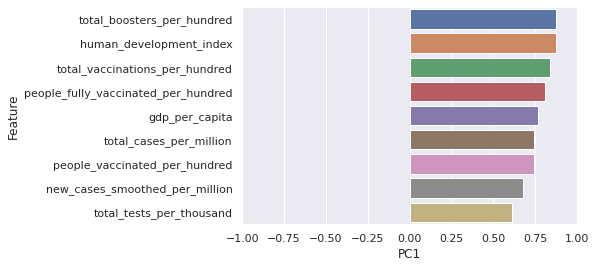

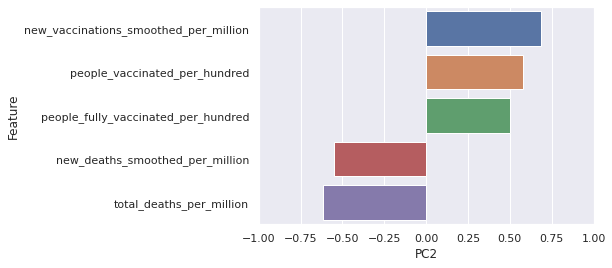

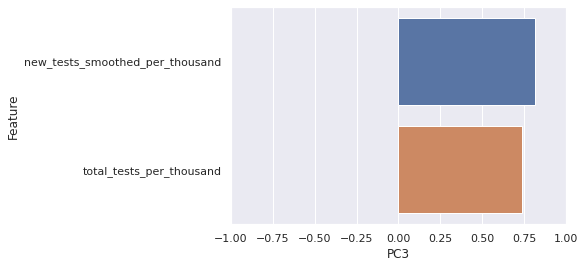

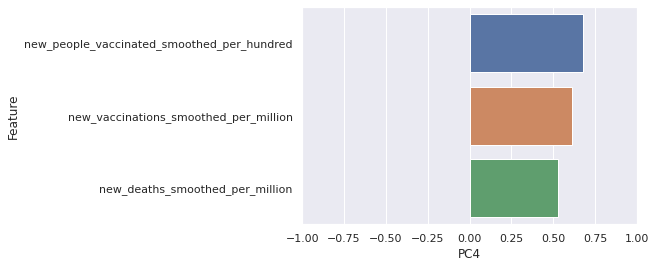

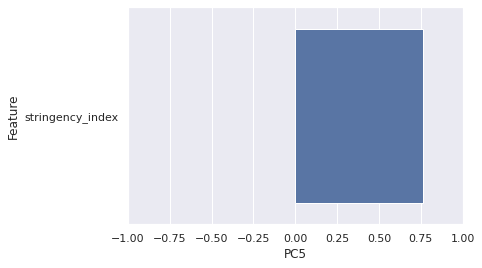

In [60]:
for col_name in df_pca_loadings_covid.columns[:5]:
  tmp_df = df_pca_loadings_covid[col_name].sort_values(key = lambda value: abs(value), ascending = False) \
    .sort_values(ascending = False)

  tmp_df = tmp_df[abs(tmp_df) > 0.5] # you can adjust this threshold to see more/less features

  # plot it
  g = sns.barplot(x = tmp_df, y = tmp_df.index)
  g.set(xlim = [-1, 1])
  plt.show()
  print()

As such, the key features of each PC is summarised as follows:

PC | Key Features
---|---
1 | Country development, Vaccinations and Cases
2 | Vaccinations and deaths
3 | COVID Tests
4 | New vaccinations and deaths
5 | Strictness of 'lockdown style' policies

### K-means Clustering

#### Choosing the number of Clusters

In [61]:
X_pc_covid = model_pca_covid.transform(X_covid) # apply the PCA model above to obtain PCs
X_pc_covid = pd.DataFrame(X_pc_covid, 
                          index = X_covid.index,
                          columns = ['PC' + str(i + 1) for i in range(model_pca_covid.n_components_)]) # convert it to a table by adding column names

X_pc_covid

,PC1,PC2,PC3,PC4,PC5,PC6
location,,,,,,
Albania,-1.694652,-1.325769,-1.047030,-0.031234,-1.085772,1.612359
Angola,-4.468335,-0.580829,0.875698,-1.111829,-0.134096,0.672170
Argentina,1.006385,0.858058,-0.949866,0.171006,0.695316,-1.469075
Australia,1.879343,1.619596,-0.792244,-0.362375,-0.115738,0.785685
Austria,4.501196,-0.396715,4.422871,-1.200507,0.413793,0.846083
...,...,...,...,...,...,...
United States,1.500717,-0.629590,-0.301566,0.061426,1.735500,-0.718817
Uruguay,1.985288,0.370976,-1.039659,0.323315,-0.716012,-1.060232
Vietnam,0.366649,1.172040,-1.906265,0.515356,-0.641134,3.249841


In [62]:
# run KMeans once from 2 clusters to 12. Extract the distance for each and add it to `ssd_list`
ssd_list = []
n_cluster_list = range(2, 13)
for n_cluster in n_cluster_list:
    model_kmeans_tmp = KMeans(n_clusters=n_cluster)
    model_kmeans_tmp.fit(X_pc_covid)
    ssd_list.append(model_kmeans_tmp.inertia_)

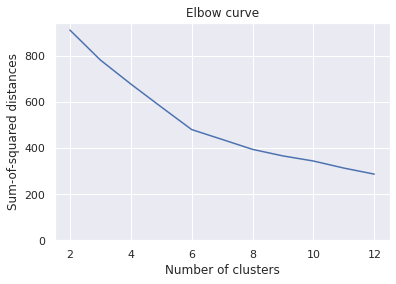

In [63]:
g = sns.lineplot(x = n_cluster_list, y = ssd_list)
g.set(
    title = 'Elbow curve', 
    xlabel = 'Number of clusters', 
    ylabel = 'Sum-of-squared distances', 
    ylim = (0, None)
)
plt.show()

* 4 is a reasonable choice here. Feel free to choose other numbers of clusters as long as you are able to draw meaningful conclusions from them.

#### Training

In [64]:
# 1. Specify a model to be trained
model_kmeans_4_covid = KMeans(n_clusters = 4, random_state = 1)

# 2. Train the model
model_kmeans_4_covid.fit(X_pc_covid)

# 3. Extract cluster number
X_pc_covid['cluster'] = model_kmeans_4_covid.predict(X_pc_covid)
X_pc_covid['cluster'] = X_pc_covid['cluster'].map(dict(X_pc_covid['cluster'].value_counts().rank().astype(int))) # rename categories such that 1 is the smallest group and 4 is the largest group
X_pc_covid['cluster'] = pd.Categorical(X_pc_covid['cluster'])
X_pc_covid['cluster']

location
Albania          3
Angola           3
Argentina        4
Australia        4
Austria          1
                ..
United States    4
Uruguay          4
Vietnam          2
Zambia           3
Zimbabwe         3
Name: cluster, Length: 94, dtype: category
Categories (4, int64): [1, 2, 3, 4]

In [65]:
X_pc_covid['cluster'].value_counts()

4    33
3    30
2    27
1     4
Name: cluster, dtype: int64

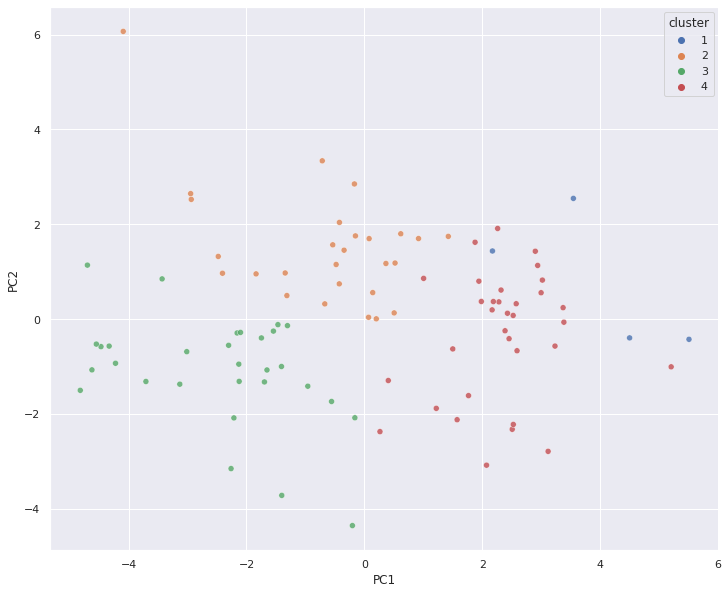

In [66]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = X_pc_covid, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

In [67]:
# make a DataFrame that combines all info: features, PCs and cluster
df_clustered_covid = pd.concat([df_covid_filtered, X_pc_covid], axis = 1)
df_clustered_covid

,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,...,stringency_index,human_development_index,gdp_per_capita,PC1,PC2,PC3,PC4,PC5,PC6,cluster
location,,,,,,,,,,,,,,,,,,,,,
Albania,94573.004,62.007,1208.521,1.044,552.997,0.092,0.6722,94.28,44.23,41.73,...,46.30,0.795,11803.431,-1.694652,-1.325769,-1.047030,-0.031234,-1.085772,1.612359,3
Angola,2909.976,0.316,55.992,0.004,41.965,0.055,0.0058,47.92,31.21,16.06,...,60.19,0.581,5819.495,-4.468335,-0.580829,0.875698,-1.111829,-0.134096,0.672170,3
Argentina,195242.086,152.086,2768.440,2.002,753.262,0.630,0.0860,205.24,88.48,79.14,...,37.04,0.845,18933.907,1.006385,0.858058,-0.949866,0.171006,0.695316,-1.469075,4
Australia,126289.150,872.619,204.318,1.352,2465.985,3.149,0.2771,210.00,85.56,79.46,...,51.39,0.944,44648.710,1.879343,1.619596,-0.792244,-0.362375,-0.115738,0.785685,4
Austria,299072.041,2978.887,1641.146,3.317,17655.132,59.284,0.0502,199.40,75.21,72.61,...,57.41,0.922,45436.686,4.501196,-0.396715,4.422871,-1.200507,0.413793,0.846083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,237581.420,186.200,2862.015,5.470,2474.373,2.962,0.0360,167.20,76.52,65.10,...,58.80,0.926,54225.446,1.500717,-0.629590,-0.301566,0.061426,1.735500,-0.718817,4
Uruguay,242284.985,845.054,2005.938,3.525,1638.063,2.949,0.2865,219.25,84.80,78.70,...,20.37,0.817,20551.409,1.985288,0.370976,-1.039659,0.323315,-0.716012,-1.060232,4
Vietnam,36239.905,970.787,410.904,1.334,807.886,1.051,0.9237,198.95,80.86,78.51,...,66.67,0.704,6171.884,0.366649,1.172040,-1.906265,0.515356,-0.641134,3.249841,2


Since we have much fewer dots in the plot, we can even annotate each dot! From this graph you may already tell the difference between clusters. 

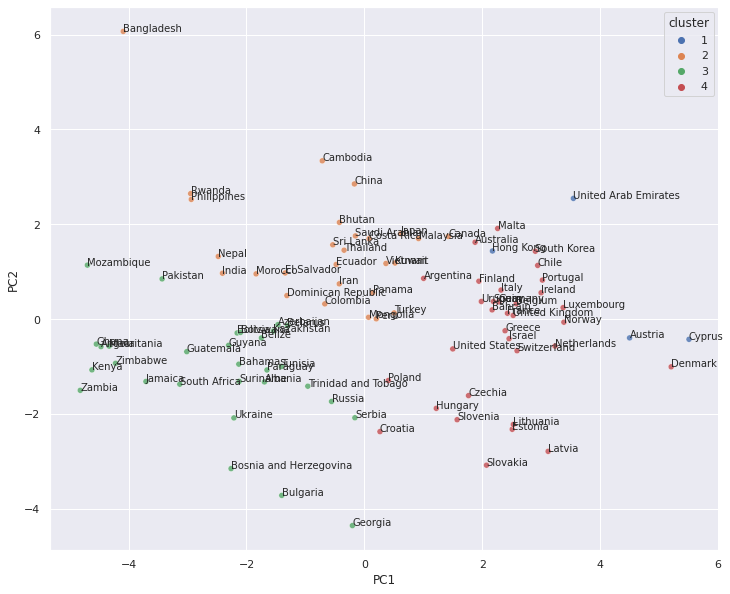

In [68]:
plt.figure(figsize = (12, 10))
g = sns.scatterplot(data = df_clustered_covid, x = 'PC1', y = 'PC2', hue = 'cluster', alpha = 0.8)

for index, row in df_clustered_covid.iterrows():
  plt.annotate(index, xy=(row['PC1'], row['PC2']), xytext=(row['PC1'], row['PC2']))

### Understanding the Clusters

In [69]:
# the longer the arrows are, the more influential the feature is in terms of PC1 and 2. 
tmp_df = df_pca_loadings_covid[['PC1', 'PC2']].copy()
tmp_df['distance'] = np.sqrt(np.square(tmp_df['PC1']) + np.square(tmp_df['PC2'])) # distance formula
tmp_df = tmp_df.sort_values(by = 'distance', key = lambda value: abs(value), ascending = False)
tmp_df['rank'] = tmp_df.reset_index().index + 1
tmp_df.head()

,PC1,PC2,distance,rank
Feature,,,,
total_vaccinations_per_hundred,0.841477,0.482740,0.970114,1
people_fully_vaccinated_per_hundred,0.808274,0.502466,0.951725,2
people_vaccinated_per_hundred,0.742604,0.581127,0.942957,3
total_boosters_per_hundred,0.876816,0.247411,0.911053,4
human_development_index,0.876262,-0.148825,0.888810,5


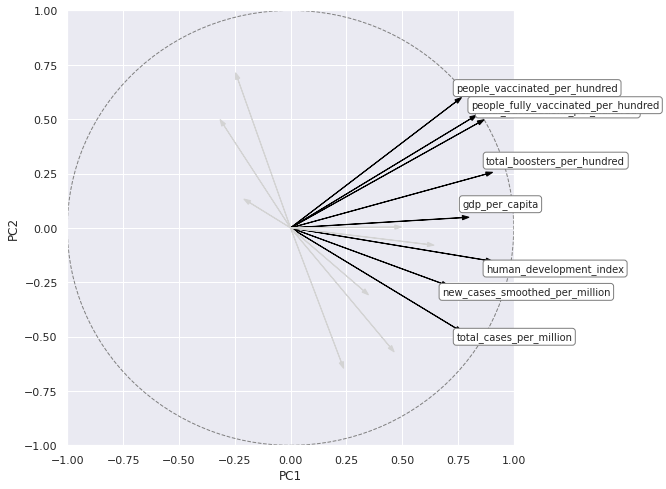

In [70]:
# unfortunately, the plot below is slightly more complex and cannot be plot using purely seaborn functions (e.g. `sns.lineplot`). We use `plt.annotate` instead.
plt.figure(figsize = (8, 8)) \
  .add_subplot().add_patch(plt.Circle((0, 0), radius=1, edgecolor='gray', ls='--', fc='None')) # plot a circle
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')

# loop through the rows above and draw an arrow for each. 
for index, row in tmp_df.iterrows():
  if row['rank'] > 8: 
    # draw a grey arrow if it's less important
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='lightgrey', head_width=0.02)
  else: 
    # draw a labelled black arrow if it's one of the most influential factors
    plt.arrow(x=0, y=0, dx=row['PC1'], dy=row['PC2'], color='black', head_width=0.02)
    plt.annotate(index, xy=(0,0), xytext=(row['PC1'], row['PC2'] + np.sign(row['PC2'])*0.05),
        bbox=dict(boxstyle="round", fc="white", ec="gray")
    )

#### Vaccinations

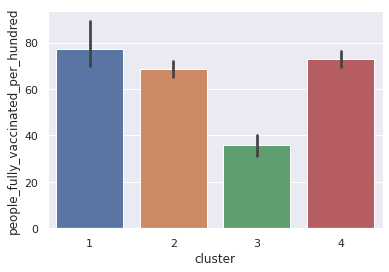

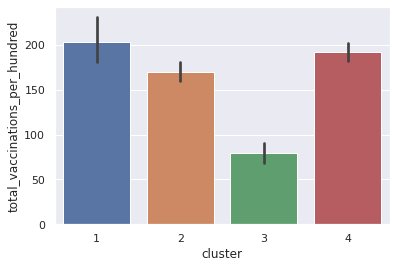

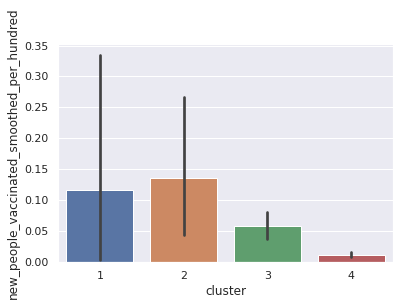

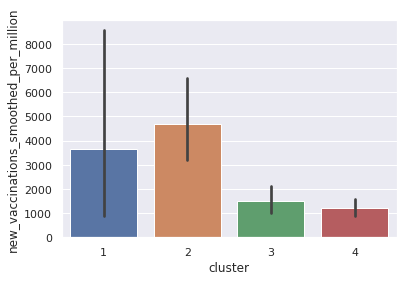

In [71]:
for col_name in ['people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 'new_people_vaccinated_smoothed_per_hundred', 'new_vaccinations_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Cluster 1 and 4 countries have the most vaccination coverage so far while cluster 3 countries have the least. 
* Cluster 2 countries are catching up with the most new vaccinations.

#### Deaths

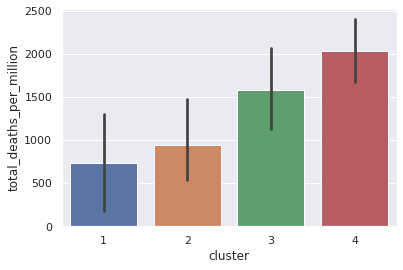

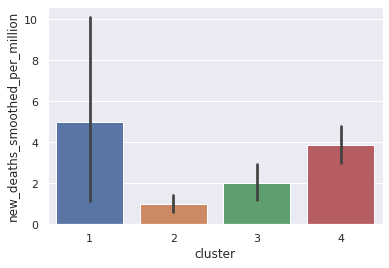

In [72]:
for col_name in ['total_deaths_per_million', 'new_deaths_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Note that the error bars of these two figures are particularly large, meaning that the number of total and new deaths vary a lot even for countries within the same cluster. We can conduct statistical tests to see if they are significantly different. 

In [73]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='total_deaths_per_million ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2.024067e+07,6.746889e+06,4.488407,0.005543
Residual,90.0,1.352863e+08,1.503181e+06,NaN,NaN


In [74]:
tmp_tukeyhsd = pairwise_tukeyhsd(endog=df_clustered_covid['total_deaths_per_million'], groups=df_clustered_covid['cluster'])
print(tmp_tukeyhsd)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff p-adj    lower      upper   reject
----------------------------------------------------------
     1      2  204.0731    0.9 -1515.4661 1923.6123  False
     1      3  839.2473 0.5657  -869.1621 2547.6566  False
     1      4 1294.8162 0.1977  -404.4328 2994.0651  False
     2      3  635.1742 0.2138  -216.2344 1486.5828  False
     2      4 1090.7431  0.005    257.868 1923.6182   True
     3      4  455.5689 0.4592  -354.0782 1265.2161  False
----------------------------------------------------------


In [75]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='new_deaths_smoothed_per_million ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,156.300987,52.100329,8.906255,0.000031
Residual,90.0,526.487238,5.849858,NaN,NaN


* We deduce that there is significant difference in total deaths (p < 0.001) and new deaths (p < 0.001) between groups. 
  * Cluster 1 countries have the lowest number of total death but highest number of new deaths (although not statistically significant). 

#### Cases

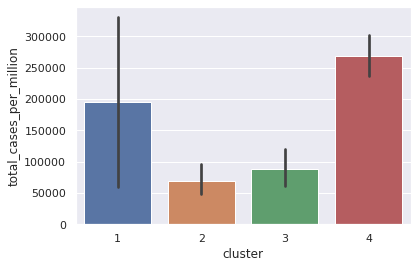

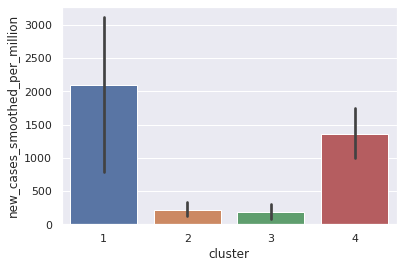

In [76]:
for col_name in ['total_cases_per_million', 'new_cases_smoothed_per_million']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* Cluster 1 countries have the most new cases.
* Cluster 4 countries have the most total cases.

#### COVID Tests

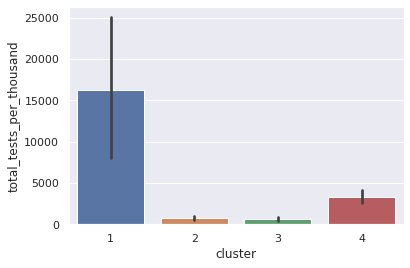

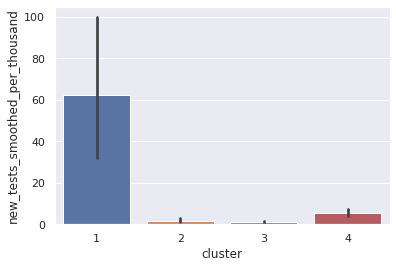

In [77]:
for col_name in ['total_tests_per_thousand', 'new_tests_smoothed_per_thousand']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

* A key distinction between Cluster 1 countries and other countries is the number of COVID tests being carried out. 

#### Country Development and Policy

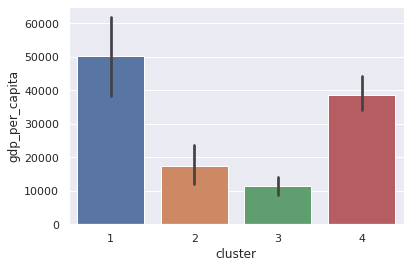

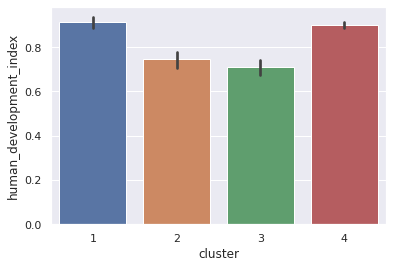

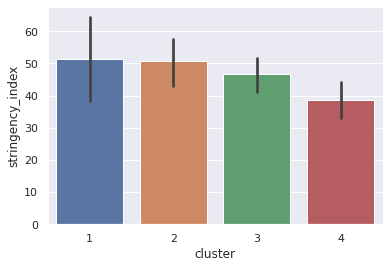

In [78]:
for col_name in ['gdp_per_capita', 'human_development_index', 'stringency_index']:
  sns.barplot(data = df_clustered_covid, x = 'cluster', y = col_name)
  plt.show()

In [79]:
# specify the independent and dependent variables in our test
model_ols = ols(formula='stringency_index ~ C(cluster)', data=df_clustered_covid).fit()

# construct an ANOVA table
aov_table = anova_lm(model_ols)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),3.0,2449.188495,816.396165,2.679642,0.051651
Residual,90.0,27419.952276,304.666136,NaN,NaN


* Cluster 2 and 3 countries have less GDP per capita, lower human development index. 
* Cluster 4 countries have the least strict COVID measures.

---

#### Characteristics of Clusters

From all the aobve, we can deduce that:

Cluster | (Predominant) Characteristics
---|---
1 | Developed countries that have a lot of recent new cases and carry out a lot of COVID tests
2 | Developing countries with little deaths and a lot of new vaccinations
3 | Developing countries with low vaccination rates
4 | Developed countries with low recent new cases but high total death cases

In [82]:
import textwrap

for cluster, group in df_clustered_covid.groupby('cluster'):
  print('--- Cluster ' + str(cluster) + ' countries ---')
  print(textwrap.fill(', '.join(group.index)))
  print()

--- Cluster 1 countries ---
Austria, Cyprus, Hong Kong, United Arab Emirates

--- Cluster 2 countries ---
Bangladesh, Bhutan, Cambodia, Canada, China, Colombia, Costa Rica,
Dominican Republic, Ecuador, El Salvador, India, Iran, Japan, Kuwait,
Malaysia, Mongolia, Morocco, Nepal, Panama, Peru, Philippines, Rwanda,
Saudi Arabia, Sri Lanka, Thailand, Turkey, Vietnam

--- Cluster 3 countries ---
Albania, Angola, Azerbaijan, Bahamas, Belarus, Belize, Bolivia, Bosnia
and Herzegovina, Botswana, Bulgaria, Georgia, Ghana, Guatemala,
Guyana, Jamaica, Kazakhstan, Kenya, Mauritania, Mozambique, Pakistan,
Paraguay, Russia, Serbia, South Africa, Suriname, Trinidad and Tobago,
Tunisia, Ukraine, Zambia, Zimbabwe

--- Cluster 4 countries ---
Argentina, Australia, Bahrain, Belgium, Chile, Croatia, Czechia,
Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland,
Israel, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands,
Norway, Poland, Portugal, Slovakia, Slovenia, South Korea, Spain,

---

# References

* [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)
* [How to perform post-hoc analysis with Tukey’s HSD test](https://nathancarter.github.io/how2data/site/how-to-perform-post-hoc-analysis-with-tukey-s-hsd-test-in-python-using-statsmodels-matplotlib-and-scikit/)